In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2022-03-19 11:34:45--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M  4.86MB/s    in 23s     

2022-03-19 11:35:08 (2.95 MB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



In [ ]:
from tqdm import tqdm
from time import sleep

for i in tqdm(range(10)):
    sleep(0.5)

100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


In [ ]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [ ]:
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomHorizontalFlip(),
    # что бы ещё поделать, чтобы увеличить размер датасета?
    # ...
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)
    # минутка эволюционной биологии: как вы думаете, почему коэффициенты именно такие?

In [ ]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 659.29it/s]


In [ ]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        # nn.MaxPool2d(),
        # nn.Dropout(),
        # nn.ReLU(),
        # nn.BatchNorm(),

    )



In [ ]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            Block(1, 16),
            Block(16, 32),
            nn.MaxPool2d((2, 2)),
            Block(32, 64),
            nn.MaxPool2d((2, 2)),
            Block(64, 128),
            Block(128, 256),
            nn.Upsample(scale_factor=2),
            Block(256, 128),
            nn.Upsample(scale_factor=2),
            Block(128, 64)
            
            # ...
            # много-много таких же, но наоборот
            # ...
        )
         
        self.postconcat = nn.Sequential(         # эту сетку можно особо не увеличивать - она не должна быть очень умной
            nn.Conv2d(65, 32, (3, 3), padding=1),# подумайте, откуда у автора тут 65
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [ ]:
num_epochs = 50
lr = 1e-3

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  # тут можно поиграться с лоссами

In [ ]:
history = []
for epoch in tqdm(range(50)):
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        colorized = model(x)

        loss = criterion(colorized, y)
        history.append(loss.item())

        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache() 

    print(history[-1])

  2%|▏         | 1/50 [06:51<5:36:17, 411.78s/it]

0.12621159851551056


  4%|▍         | 2/50 [13:51<5:33:06, 416.38s/it]

0.08310190588235855


  6%|▌         | 3/50 [20:50<5:27:11, 417.70s/it]

0.07886851578950882


  8%|▊         | 4/50 [27:49<5:20:39, 418.25s/it]

0.07161129266023636


 10%|█         | 5/50 [34:50<5:14:26, 419.25s/it]

0.07007313519716263


 12%|█▏        | 6/50 [41:57<5:09:14, 421.70s/it]

0.07704606652259827


 14%|█▍        | 7/50 [49:03<5:03:10, 423.04s/it]

0.0715034231543541


 16%|█▌        | 8/50 [56:03<4:55:29, 422.14s/it]

0.07266039401292801


 18%|█▊        | 9/50 [1:03:03<4:48:07, 421.65s/it]

0.06535056978464127


 20%|██        | 10/50 [1:10:02<4:40:29, 420.73s/it]

0.061624109745025635


 22%|██▏       | 11/50 [1:17:00<4:32:51, 419.78s/it]

0.05539935827255249


 24%|██▍       | 12/50 [1:24:01<4:26:06, 420.18s/it]

0.06184494122862816


 26%|██▌       | 13/50 [1:31:01<4:19:11, 420.31s/it]

0.058643653988838196


 28%|██▊       | 14/50 [1:38:02<4:12:19, 420.54s/it]

0.05957251042127609


 30%|███       | 15/50 [1:45:06<4:05:51, 421.46s/it]

0.0653356984257698


 32%|███▏      | 16/50 [1:52:08<3:58:56, 421.67s/it]

0.055187612771987915


 34%|███▍      | 17/50 [1:59:06<3:51:14, 420.44s/it]

0.06354470551013947


 36%|███▌      | 18/50 [2:06:04<3:43:49, 419.66s/it]

0.06606146693229675


 38%|███▊      | 19/50 [2:13:01<3:36:31, 419.08s/it]

0.06201896816492081


 40%|████      | 20/50 [2:19:59<3:29:16, 418.54s/it]

0.0633564218878746


 42%|████▏     | 21/50 [2:26:59<3:22:35, 419.15s/it]

0.060902535915374756


 44%|████▍     | 22/50 [2:33:57<3:15:25, 418.78s/it]

0.05501687526702881


 46%|████▌     | 23/50 [2:40:57<3:08:33, 419.00s/it]

0.0639697015285492


 48%|████▊     | 24/50 [2:47:58<3:01:54, 419.78s/it]

0.054445140063762665


 50%|█████     | 25/50 [2:54:57<2:54:45, 419.40s/it]

0.05956565961241722


 52%|█████▏    | 26/50 [3:01:58<2:47:55, 419.83s/it]

0.05653806030750275


 54%|█████▍    | 27/50 [3:09:00<2:41:14, 420.63s/it]

0.054381392896175385


 56%|█████▌    | 28/50 [3:15:57<2:33:51, 419.60s/it]

0.06424088776111603


 58%|█████▊    | 29/50 [3:22:57<2:26:53, 419.67s/it]

0.059807926416397095


 60%|██████    | 30/50 [3:29:54<2:19:37, 418.89s/it]

0.05795588716864586


 62%|██████▏   | 31/50 [3:36:53<2:12:39, 418.93s/it]

0.060693029314279556


 64%|██████▍   | 32/50 [3:43:58<2:06:12, 420.67s/it]

0.05771876871585846


 66%|██████▌   | 33/50 [3:50:59<1:59:12, 420.73s/it]

0.05426200479269028


 68%|██████▊   | 34/50 [3:57:59<1:52:09, 420.62s/it]

0.05581589788198471


 70%|███████   | 35/50 [4:04:57<1:44:58, 419.92s/it]

0.053688351064920425


 72%|███████▏  | 36/50 [4:11:58<1:38:01, 420.08s/it]

0.05708569660782814


 74%|███████▍  | 37/50 [4:18:55<1:30:50, 419.28s/it]

0.05909222736954689


 76%|███████▌  | 38/50 [4:26:00<1:24:10, 420.83s/it]

0.05690953880548477


 78%|███████▊  | 39/50 [4:33:00<1:17:08, 420.77s/it]

0.05441322177648544


 80%|████████  | 40/50 [4:40:03<1:10:12, 421.27s/it]

0.05566605553030968


 82%|████████▏ | 41/50 [4:47:05<1:03:13, 421.47s/it]

0.05073991417884827


 84%|████████▍ | 42/50 [4:54:08<56:15, 421.99s/it]  

0.05210326239466667


 86%|████████▌ | 43/50 [5:01:08<49:09, 421.42s/it]

0.05881465598940849


 88%|████████▊ | 44/50 [5:08:08<42:06, 421.01s/it]

0.052177682518959045


 90%|█████████ | 45/50 [5:15:07<35:01, 420.29s/it]

0.05044149234890938


 92%|█████████▏| 46/50 [5:22:10<28:04, 421.13s/it]

0.05265025049448013


 94%|█████████▍| 47/50 [5:29:11<21:03, 421.26s/it]

0.056754302233457565


 96%|█████████▌| 48/50 [5:36:10<14:00, 420.39s/it]

0.04902131110429764


 98%|█████████▊| 49/50 [5:43:08<06:59, 419.79s/it]

0.051995351910591125


100%|██████████| 50/50 [5:50:10<00:00, 420.20s/it]

0.04971136525273323


In [ ]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

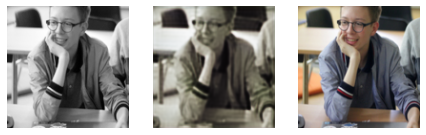

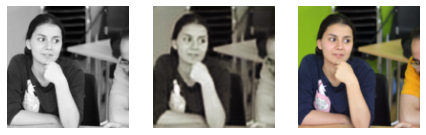

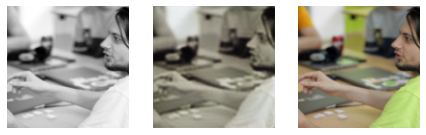

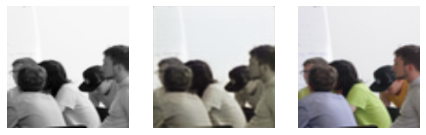

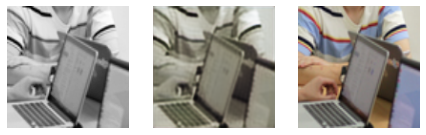

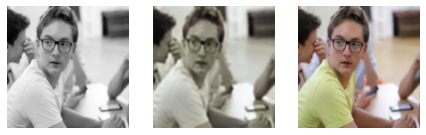

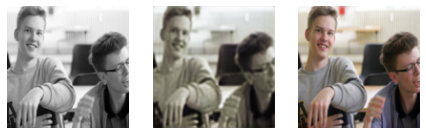

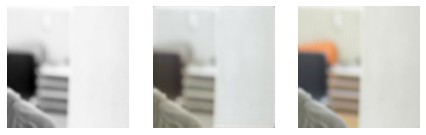

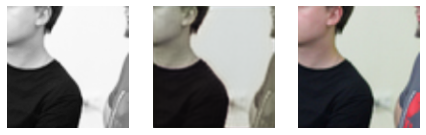

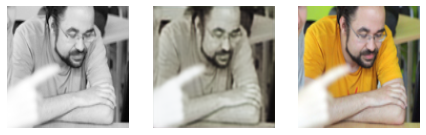

In [ ]:
for t in range(10):
    img_gray, img_true = dataset[t]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    # теперь это numpy-евский ndarray размера (128, 128, 3)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()